<a href="https://colab.research.google.com/github/Jungkihong07/Deepwave/blob/main/hyperparameter_tuning_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!unzip /content/2501ml_data.zip -d /content/

unzip:  cannot find or open /content/2501ml_data.zip, /content/2501ml_data.zip.zip or /content/2501ml_data.zip.ZIP.


In [ ]:
!file /content/2501ml_data.zip

/content/2501ml_data.zip: Zip archive data, at least v2.0 to extract, compression method=deflate


## 1. 필요 라이브러러 임포트 및 다운로드

In [10]:
# -------------------------------------------
# 1. 라이브러리 설치 및 임포트
# -------------------------------------------
!pip install umap-learn --quiet

import os
import random
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy

# 재현성 설정
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


## 데이터 로딩 함수 정의

In [16]:
# -------------------------------------------
# 2. 데이터 로딩 함수 정의
# -------------------------------------------
def load_mfcc_data(audio_path, label_path, max_len=200):
    entries = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                entries.append((parts[1], parts[-1]))
    df = pd.DataFrame(entries, columns=['filename','label'])

    X_list, y_list = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Loading MFCC"):
        fp = os.path.join(audio_path, row['filename'])
        if not os.path.isfile(fp):
            continue
        try:
            audio, sr = librosa.load(fp, sr=16000)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20).T # 기존에는 13이었음.
            if mfcc.shape[0] < max_len:
                mfcc = np.pad(mfcc, ((0, max_len-mfcc.shape[0]), (0,0)), mode='constant')
            else:
                mfcc = mfcc[:max_len]
            X_list.append(mfcc)
            y_list.append(0 if row['label']=='Real' else 1)
        except:
            continue

    return np.array(X_list), np.array(y_list)


def standardize(X):
    ns, nt, nf = X.shape
    scaler = StandardScaler().fit(X.reshape(-1, nf))
    X_scaled = scaler.transform(X.reshape(-1, nf)).reshape(ns, nt, nf)
    return X_scaled, scaler


### 데이터 셋 캐시 저장
- 사용 예시
save_mfcc_cache(X, y, scaler, cache_prefix="train")
- 사용 조건
  - 목차의 "캐시가 없을 때"를 실행하고 난 후 실행하셔야 합니다.

#### Train set 캐시 저장 함수
- test set을 위한 코드가 아닙니다. train set에만 사용하시기 바랍니다.

In [33]:
def save_mfcc_cache(X, y, scaler, cache_prefix="train"):
    X_cache = f"{cache_prefix}_X.npy"
    y_cache = f"{cache_prefix}_y.npy"
    scaler_cache = f"{cache_prefix}_scaler.npy"

    np.save(X_cache, X)
    np.save(y_cache, y)
    np.save(scaler_cache, {'mean': scaler.mean_, 'scale': scaler.scale_})
    print(f"✅ 캐시 저장 완료: {X_cache}, {y_cache}, {scaler_cache}")
# Train set = > X: 전처리된 입력 특성, y : 정답 레이블, scaler : 표준화 정보
save_mfcc_cache(X, y, scaler, cache_prefix="/content/drive/MyDrive/2501ml_data/cache/train")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/2501ml_data/cache/train_X.npy'

#### Test set 캐시 저장
-  test set을 위한 코드입니다.

In [34]:
test_X_path = "/content/drive/MyDrive/2501ml_data/cache/test_X.npy"
test_y_path = "/content/drive/MyDrive/2501ml_data/cache/test_y.npy"

# Test set => X_test : 입력 특성, y_test : 정답 레이블, 표준화 정보는 필요없음. scalar를 사용해야 함.
np.save(test_X_path, X_test)
np.save(test_y_path, y_test)
print("✅ 테스트셋 캐시 저장 완료")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/2501ml_data/cache/test_X.npy'

### 캐시로부터 MFCC 데이터 로드 함수
- 사용 예시
X, y, scaler = load_mfcc_cache(cache_prefix="train")
- 사용 조건
  - 이후 캐시를 저장하고 난 후는 계속해서 MFCC 데이터 로드 함수를 활용해 이후, 로드할 필요 없이 사용하시면 됩니다.

#### Train set 캐시 로드 함수

In [35]:
def load_mfcc_cache(cache_prefix="train"):
    X_cache = f"{cache_prefix}_X.npy"
    y_cache = f"{cache_prefix}_y.npy"
    scaler_cache = f"{cache_prefix}_scaler.npy"

    if not (os.path.exists(X_cache) and os.path.exists(y_cache) and os.path.exists(scaler_cache)):
        raise FileNotFoundError(f"❌ 캐시 파일이 존재하지 않습니다: prefix={cache_prefix}")

    print(f"📂 캐시 불러오는 중: {X_cache}, {y_cache}")
    X = np.load(X_cache)
    y = np.load(y_cache)
    scaler_params = np.load(scaler_cache, allow_pickle=True).item()

    scaler = StandardScaler()
    scaler.mean_ = scaler_params['mean']
    scaler.scale_ = scaler_params['scale']

    return X, y, scaler
# Train set
X, y, scaler = load_mfcc_cache(cache_prefix="/content/drive/MyDrive/2501ml_data/cache/train")

FileNotFoundError: ❌ 캐시 파일이 존재하지 않습니다: prefix=/content/drive/MyDrive/2501ml_data/cache/train

#### test set 캐시 로드

In [36]:
test_X_path = "/content/drive/MyDrive/2501ml_data/cache/test_X.npy"
test_y_path = "/content/drive/MyDrive/2501ml_data/cache/test_y.npy"
# Test set
X_test = np.load(test_X_path)
y_test = np.load(test_y_path)
print("✅ 테스트셋 캐시 불러오기 완료")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/2501ml_data/cache/test_X.npy'

## DNN 모델 정의

In [24]:
def build_dnn_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape, name="input_mfcc"),
        layers.Flatten(name="flatten"),

        layers.Dense(64, activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(128, activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4),

        layers.Dense(1, activation='sigmoid', name="output")
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [25]:
def build_dnn_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## 학습용 데이터 로딩

In [11]:
train_audio_path = '/content/drive/MyDrive/2501ml_data/train'
train_label_path = '/content/drive/MyDrive/2501ml_data/label/train_label.txt'


### 캐시가 없을 때
- 캐시가 있다면 목차의 "캐시로부터 MFCC 데이터 로드 함수"를 실행하고 난후 다음 단계로 넘어가주시기 바랍니다.

In [12]:
max_len = 4000
X, y = load_mfcc_data(train_audio_path, train_label_path, max_len)
X, scaler = standardize(X)

Loading MFCC: 100%|██████████| 4000/4000 [24:55<00:00,  2.67it/s]


# 모델 학습

In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=41
)

model = build_dnn_model(input_shape=(max_len, X.shape[2]))
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7941 - loss: 0.8791 - val_accuracy: 0.9725 - val_loss: 0.0850 - learning_rate: 0.0010
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9705 - loss: 0.0835 - val_accuracy: 0.9787 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9707 - loss: 0.0928 - val_accuracy: 0.9850 - val_loss: 0.0769 - learning_rate: 0.0010
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9729 - loss: 0.0693 - val_accuracy: 0.9912 - val_loss: 0.0595 - learning_rate: 0.0010
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9770 - loss: 0.0614 - val_accuracy: 0.9887 - val_loss: 0.0444 - learning_rate: 0.0010
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9785 - loss: 0.0567 - val_accuracy: 0.9837 - val_loss: 0.0649 - learning_rate: 0.0010
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9810 - loss: 0.0678 -

In [28]:
from sklearn.utils.class_weight import compute_class_weight

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=41
)

model = build_dnn_model(input_shape=(max_len, X.shape[2]))
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7560 - loss: 0.9663 - val_accuracy: 0.9862 - val_loss: 0.0528 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9660 - loss: 0.1047 - val_accuracy: 0.9862 - val_loss: 0.0500 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9890 - loss: 0.0409 - val_accuracy: 0.9850 - val_loss: 0.0471 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9819 - loss: 0.0469 - val_accuracy: 0.9887 - val_loss: 0.0402 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9839 - loss: 0.0380 - val_accuracy: 0.9912 - val_loss: 0.0662 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9802 - loss: 0.0854 - val_accuracy: 0.9862 - val_loss: 0.0515 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9888 - loss: 0.

## 모델 학습 과정 시각화

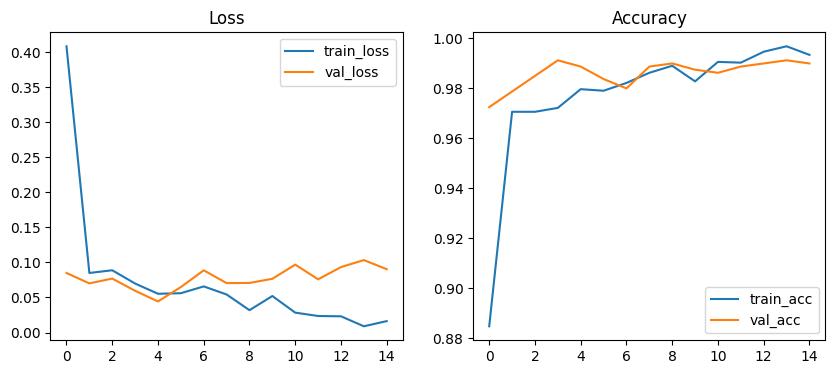

In [29]:
def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title("Accuracy")
    plt.legend()
    plt.show()

plot_history(history)
model.save("dnn_model.h5")

# 테스트 데이터 로딩 및 평가

In [30]:
test_audio_path = '/content/drive/MyDrive/2501ml_data/test'
test_label_path = '/content/drive/MyDrive/2501ml_data/label/test_label.txt'

### 캐시가 없을 때
- 캐시가 있다면 목차의 "캐시로부터 MFCC 데이터 로드 함수"를 실행하고 난후 다음 단계로 넘어가주시기 바랍니다.
- 캐시를 생성하고 싶다면 목차의 "데이터 셋 캐시 저장"을 실행하시기 바립니다.

In [31]:
X_test, y_test = load_mfcc_data(test_audio_path, test_label_path, max_len)

ns_test = X_test.shape[0]
X_test, _ = standardize(X_test)

Loading MFCC: 100%|██████████| 2000/2000 [13:58<00:00,  2.39it/s]


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

✅ Classification Report - TEST DATA
              precision    recall  f1-score   support

        Real       0.85      1.00      0.92      1000
        Fake       1.00      0.83      0.90      1000

    accuracy                           0.91      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.91      0.91      2000

ROC AUC: 0.909


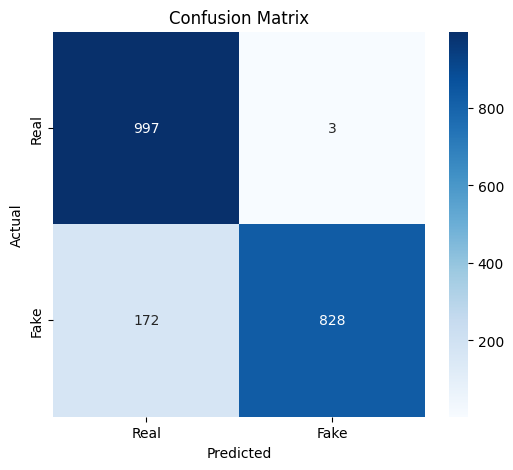

In [37]:
# -------------------------------------------
# 6. 테스트 데이터 평가
# -------------------------------------------

y_prob = model.predict(X_test)
y_pred = (y_prob > 0.8).astype(int)

print("\n✅ Classification Report - TEST DATA")
print(classification_report(y_test, y_pred, target_names=['Real','Fake']))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Spectral_Contrast 특징 활용 모델
- 오분류된 데이터에 대해서 따로 특징을 추출하여 분류를 시도함. 이를 활용하여 약 1% 성능 향상이 가능하였음.

In [38]:
def predict_with_spectral_contrast(model,X_test, score:float = 0.32):
    # 🔹 1. DNN 예측
    y_prob = model.predict(X_test).flatten()

    # 🔹 2. 보정 대상: 확률이 낮은 샘플
    uncertain_idx = np.where(y_prob < score)[0]

    # 🔹 3. test_label.txt에서 파일 이름 가져오기
    df = pd.read_csv(test_label_path, sep='\s+', header=None, usecols=[1, 4], names=['filename', 'label'])

    # 라벨을 숫자로 변환
    df['label'] = df['label'].map({'Real': 0, 'Fake': 1})

    # 리스트와 배열로 추출
    test_filenames = df['filename'].tolist()
    y_test = df['label'].values.astype(int)

    # # 확인
    # print("✅ 파일 예시:", test_filenames[:5])
    # print("✅ 라벨 분포:", pd.Series(y_test).value_counts().to_dict())


    # 🔹 4. Spectral contrast 기반 보정
    for idx in tqdm(uncertain_idx, desc="📌 Spectral Contrast 보정 중"):
        filename = test_filenames[idx]
        file_path = os.path.join(test_audio_path, filename)

        try:
            y, sr = librosa.load(file_path, sr=16000)
            contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
            high_contrast = np.mean(contrast[-2:, :])  # 고주파 2대역 평균

            if (high_contrast < 21.0 or high_contrast > 27.0):
                y_prob[idx] = 1.0  # Fake로 강제 보정
        except Exception as e:
            print(f"⚠️ Error processing {filename}: {e}")
    return y_prob

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


📌 Spectral Contrast 보정 중: 100%|██████████| 1152/1152 [00:09<00:00, 121.02it/s]



✅ Classification Report - TEST DATA
              precision    recall  f1-score   support

        Real       0.88      0.99      0.93      1000
        Fake       0.99      0.86      0.92      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

ROC AUC: 0.921


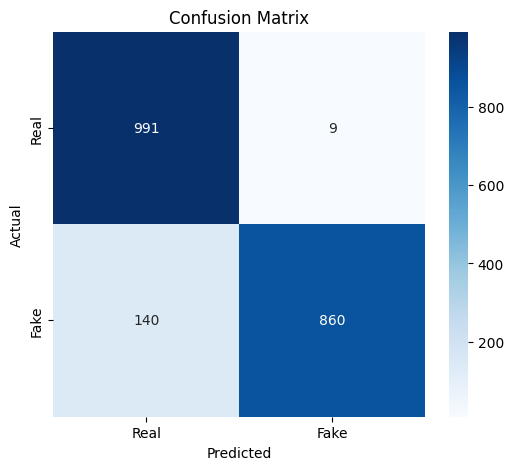

In [39]:
# 🔹 5. 최종 이진 판정 (확률 기준은 0.5 유지)
y_prob = predict_with_spectral_contrast(model,X_test, score=0.5)
y_pred = (y_prob >= 0.5).astype(int)
print("\n✅ Classification Report - TEST DATA")
print(classification_report(y_test, y_pred, target_names=['Real','Fake']))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Spectral contrast 최적화 기준 자동화 선별 함수 (실험 코드)

In [42]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

import os

# 1) 실제 오디오 파일들이 들어 있는 디렉토리 경로
train_audio_path = '/content/drive/MyDrive/2501ml_data/train'

# 2) 해당 폴더에 있는 모든 .wav 파일 이름을 리스트로 가져오기
test_filenames = sorted([
    f for f in os.listdir(test_audio_path)
    if f.lower().endswith('.wav')
])


def run_experiment(model, X_test, y_test, test_filenames, test_audio_path,
                   prob_thresholds=[0.3, 0.4, 0.5, 0.6],
                   contrast_bounds=[(22.0, 26.0), (23.0, 26.5), (22.5, 27.0)]):

    results = []

    for prob_thresh in prob_thresholds:
        for contrast_low, contrast_high in contrast_bounds:
                    # 1. DNN 확률 예측
          y_prob = model.predict(X_test).flatten()

          # 2. 보정 대상 (확률 기준 이하)
          uncertain_idx = np.where(y_prob < prob_thresh)[0]

          # 3. Spectral Contrast 보정
          for idx in tqdm(uncertain_idx, desc=f"🔍 p<{prob_thresh}, c<{contrast_low} or >{contrast_high}"):
              file_path = os.path.join(test_audio_path, test_filenames[idx])
              try:
                  y, sr = librosa.load(file_path, sr=16000)
                  contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
                  high_contrast = np.mean(contrast[-2:, :])

                  # Fake로 보정 조건
                  if high_contrast < contrast_low or high_contrast > contrast_high:
                      y_prob[idx] = 1.0  # Fake로 강제 보정
              except Exception as e:
                  print(f"⚠️ Error: {file_path} - {e}")
          for a in prob_thresholds:
            # 4. 이진 결과
            y_pred = (y_prob >= a).astype(int)

            # 5. 지표 계산
            acc = accuracy_score(y_test, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

            # 6. 기록
            results.append({
                'a' : a,
                'prob_thresh': prob_thresh,
                'contrast_low': contrast_low,
                'contrast_high': contrast_high,
                'accuracy': acc,
                'precision': precision,
                'recall': recall,
                'f1': f1
            })

    return pd.DataFrame(results)

In [43]:
# 실험 설정 값
prob_thresholds = [0.32]
contrast_bounds = [(21,27),(20.5, 27.5)]

# 실행
result_df = run_experiment(model, X_test, y_test, test_filenames, test_audio_path,
                           prob_thresholds, contrast_bounds)

# 결과 출력 (F1-score 기준 정렬)
result_df_sorted = result_df.sort_values(by='f1', ascending=False).reset_index(drop=True)

from IPython.display import display
display(result_df_sorted)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


🔍 p<0.32, c<21 or >27: 100%|██████████| 1150/1150 [00:23<00:00, 48.85it/s] 


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


🔍 p<0.32, c<20.5 or >27.5: 100%|██████████| 1150/1150 [00:11<00:00, 99.50it/s] 


,a,prob_thresh,contrast_low,contrast_high,accuracy,precision,recall,f1
0,0.32,0.32,20.5,27.5,0.9135,0.921888,0.9135,0.913068
1,0.32,0.32,21.0,27.0,0.9080,0.914582,0.9080,0.907633


# 예측 결과 파일 작성

In [44]:
from sklearn.preprocessing import LabelEncoder

# 1. test 파일명 리스트 로딩
def get_test_filenames(label_path):
    filenames = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                filenames.append(parts[1])
    return filenames

# 2. LabelEncoder: Fake → 0, Real → 1
le = LabelEncoder()
le.fit(['Fake', 'Real']) # 반드시 이 순서로 지정해야 0=Fake, 1=Real

# 3. 파일 이름 로드
test_file_names = get_test_filenames(test_label_path)

# 4. 예측 확률 → 클래스 (0 또는 1) => 정규화 방식에 따라 정확도가 차이가 남.
y_pred_prob =predict_with_spectral_contrast(model,X_test, score=0.5)
# y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_pred_classes = (y_pred_prob <= 0.5).astype(int).flatten()  # 확률 → 0 or 1


# 5. 예측 결과 파일 작성
with open('./team_test_result.txt', 'w') as f:
    for i in range(len(y_pred_classes)):
        label_str = le.inverse_transform([y_pred_classes[i]])[0]  # 0 → Fake, 1 → Real
        f.write(f"{test_file_names[i]} {label_str}\n")

print("✅ team_test_result.txt 저장 완료 (Perl 평가용)")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


📌 Spectral Contrast 보정 중: 100%|██████████| 1152/1152 [00:09<00:00, 120.47it/s]


✅ team_test_result.txt 저장 완료 (Perl 평가용)


In [45]:
!perl /content/drive/MyDrive/2501ml_data/eval.pl ./team_test_result.txt /content/drive/MyDrive/2501ml_data/label/test_label.txt

============ Results Analysis ===========
Test: ./team_test_result.txt
True: /content/drive/MyDrive/2501ml_data/label/test_label.txt
Accuracy: 92.55%
Hit: 1851, Total: 2000
